In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# NOTE: change destination folder of dataset to suit.
sentiment140_data = pd.read_csv("datasets/training.1600000.processed.noemoticon.csv", 
                                encoding="ISO-8859-1", header=None, names=["target","id","date","flag","user","text"])

In [3]:
# SAMPLING
sentiment140_data = sentiment140_data.sample(frac=0.1, random_state=42)

# Data Exploration

In [4]:
sentiment140_data.head()

,target,id,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [5]:
sentiment140_data.tail()

,target,id,date,flag,user,text
1574177,4,2189199207,Mon Jun 15 23:28:21 PDT 2009,NO_QUERY,mainbasket,@willjonz thank you Will
49646,0,1678213724,Sat May 02 05:56:37 PDT 2009,NO_QUERY,MagicElla,@HeartlessHippie AAAAAAAAH what's wrong?!
1317229,4,2014242841,Wed Jun 03 00:53:53 PDT 2009,NO_QUERY,kewlrats,@samhouston Will see you there tomorrow at the...
520455,0,2192116541,Tue Jun 16 06:32:06 PDT 2009,NO_QUERY,iXombie,Forgot that Xbox Live would be down today.
427964,0,2063837266,Sun Jun 07 04:16:08 PDT 2009,NO_QUERY,laura0108,So I got up at 12 today and I have to get up a...


In [6]:
sentiment140_data.columns

Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')

In [7]:
len(sentiment140_data)

160000

In [8]:
sentiment140_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160000 entries, 541200 to 427964
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  160000 non-null  int64 
 1   id      160000 non-null  int64 
 2   date    160000 non-null  object
 3   flag    160000 non-null  object
 4   user    160000 non-null  object
 5   text    160000 non-null  object
dtypes: int64(2), object(4)
memory usage: 8.5+ MB


In [9]:
np.sum(sentiment140_data.isnull().any(axis=1))

0

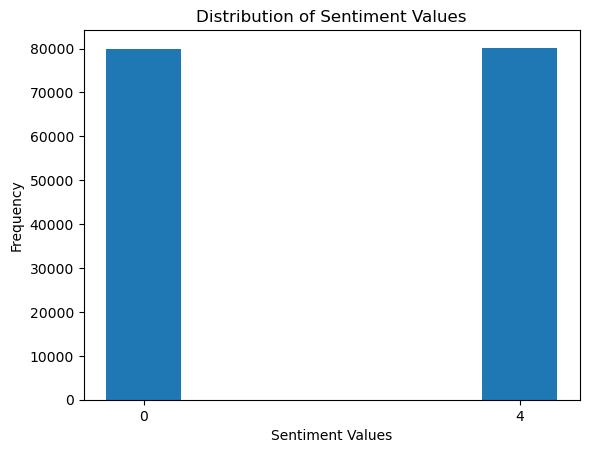

In [10]:
# Bar chart to check for data imbalance.
value_counts = sentiment140_data["target"].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Sentiment Values")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Values")
plt.xticks(value_counts.index)
plt.show()

# Data Preprocessing

## Drop columns that arent needed

In [11]:
data = sentiment140_data.drop(["id","date","flag","user"], axis=1)

In [12]:
data.head()

,target,text
541200,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,@TiannaChaos i know just family drama. its la...
285055,0,School email won't open and I have geography ...
705995,0,upper airways problem


## Convert sentiment target values from integer to string

In [13]:
LABEL_MAP = {0:"Negative", 2:"Neutral", 4:"Positive"}
def label_decoder(label):
    return LABEL_MAP[label]

In [14]:
data.target = data.target.apply(lambda x: label_decoder(x))
data.head()

,target,text
541200,Negative,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,Negative,"@misstoriblack cool , i have no tweet apps fo..."
766711,Negative,@TiannaChaos i know just family drama. its la...
285055,Negative,School email won't open and I have geography ...
705995,Negative,upper airways problem


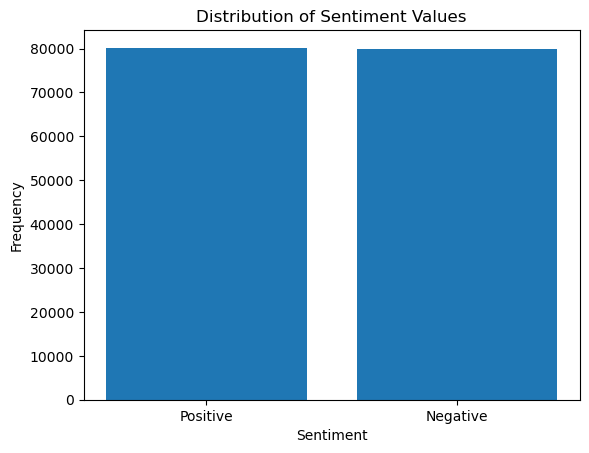

In [15]:
value_counts = data["target"].value_counts()
plt.bar(value_counts.index, value_counts.values)
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Values")
plt.xticks(value_counts.index)
plt.show()

## Data Cleaning

In [16]:
nltk.download('stopwords', quiet=True)

True

In [17]:
# TODO: handle emojis if time
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TEXT_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [18]:
def preprocess(text, stem=False):
    text = re.sub(TEXT_RE, " ", str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [19]:
%%time
data["text"] = data["text"].apply(lambda x: preprocess(x))
data.head()

CPU times: total: 1.72 s
Wall time: 4.06 s


,target,text
541200,Negative,ahhh hope ok
750,Negative,cool tweet apps razr 2
766711,Negative,know family drama lame hey next time u hang ki...
285055,Negative,school email open geography stuff revise stupi...
705995,Negative,upper airways problem


## Train Test Split

In [20]:
# TODO: remove X and Y later when/if not needed
X = data["text"]
y = data["target"]

TRAIN_SIZE = 0.7
train, test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
X_train = train["text"]
X_test = test["text"]
y_train = train["target"]
y_test = test["target"]

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(111999,)
(48001,)
(111999,)
(48001,)


In [22]:
X.head()

541200                                         ahhh hope ok
750                                  cool tweet apps razr 2
766711    know family drama lame hey next time u hang ki...
285055    school email open geography stuff revise stupi...
705995                                upper airways problem
Name: text, dtype: object

In [23]:
y.head()

541200    Negative
750       Negative
766711    Negative
285055    Negative
705995    Negative
Name: target, dtype: object

# Feature Extraction

## TF-IDF

In [24]:
NGRAM_RANGE = (1,2)
#MAX_FEATURES = 50000
tfidf = TfidfVectorizer(ngram_range=NGRAM_RANGE)

In [25]:
%%time
tfidf.fit(X_train)

CPU times: total: 3.44 s
Wall time: 4.87 s


TfidfVectorizer(ngram_range=(1, 2))

In [26]:
%%time
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

CPU times: total: 3.03 s
Wall time: 5.23 s


## Word Embedding

### Word Tokenization for Embedding

In [27]:
# NLTK tokenizer
from nltk.tokenize import RegexpTokenizer
regexp = RegexpTokenizer(r'\w+')
X_train_tk = X_train.apply(regexp.tokenize)
X_train_tk.head()

229771                                                 [bad]
1193312    [played, cute, nephew, today, gonna, go, dinne...
1468679    [could, sunny, everyday, rain, cold, weather, ...
1195724                         [n, dont, worry, back, soon]
794333                         [nooooo, leave, 5, 30, today]
Name: text, dtype: object

In [28]:
len(X_train_tk)

111999

### Word2Vec

In [29]:
import gensim
from gensim.models import Word2Vec

In [30]:
%%time
VECTOR_SIZE = 300
EPOCHS = 16
word2Vec = gensim.models.Word2Vec(X_train_tk, min_count=5, vector_size=VECTOR_SIZE, window=5, workers=8, sg=1, epochs=EPOCHS, seed=42)

CPU times: total: 2min 45s
Wall time: 26.7 s


In [31]:
word2Vec.wv.most_similar('weather', topn=5)

[('cloudy', 0.5341755151748657),
 ('sunny', 0.5191501379013062),
 ('rainy', 0.5126966834068298),
 ('humid', 0.5032073855400085),
 ('gloom', 0.501520037651062)]

In [32]:
word2Vec.save("word2Vec.model")

In [33]:
word2Vec = Word2Vec.load("word2Vec.model")

### Label Encoding

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train.tolist())
y_test_le = le.transform(y_test.tolist())

y_train_le = y_train_le.reshape(-1,1)
y_test_le = y_test_le.reshape(-1,1)

# Machine Learning Models

## Support Vector Machine

## Long Short-Term Memory Network

### Tokenization and Padding

In [36]:
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

In [37]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 77822
CPU times: total: 4.42 s
Wall time: 5.49 s


In [38]:
%%time
MAX_SEQUENCE_LENGTH = 100
X_train_tk = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_SEQUENCE_LENGTH)
X_test_tk = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_SEQUENCE_LENGTH)

print(X_train_tk.shape)
print(X_test_tk.shape)

(111999, 100)
(48001, 100)
CPU times: total: 2.88 s
Wall time: 3.67 s


### Model

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [40]:
embedding_matrix = np.zeros((vocab_size, VECTOR_SIZE))
for word, i in tokenizer.word_index.items():
    if word in word2Vec.wv:
        embedding_matrix[i] = word2Vec.wv[word]
print(embedding_matrix.shape)

(77822, 300)


In [41]:
embedding_layer = Embedding(
    vocab_size, 
    VECTOR_SIZE, 
    weights=[embedding_matrix], 
    input_length=MAX_SEQUENCE_LENGTH, 
    trainable=False )

In [42]:
lstm = Sequential()
lstm.add(embedding_layer)
lstm.add(Dropout(0.5))
lstm.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(1))

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          23346600  
                                                                 
 dropout (Dropout)           (None, 100, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 23440105 (89.42 MB)
Trainable params: 93505 (365.25 KB)
Non-trainable params: 23346600 (89.06 MB)
_________________________________________________________________


In [43]:
%%time
lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

CPU times: total: 0 ns
Wall time: 13.5 ms


In [44]:
# TODO: change epochs
history = lstm.fit(
    X_train_tk, y_train_le,
    batch_size=1024,
    epochs=8,
    validation_split=0.1,
    verbose=1,
    )

Epoch 1/8
99/99 [==============================] - 341s 3s/step - loss: 0.8154 - accuracy: 0.5665 - val_loss: 0.6302 - val_accuracy: 0.6537
Epoch 2/8
99/99 [==============================] - 358s 4s/step - loss: 0.6173 - accuracy: 0.6679 - val_loss: 0.5584 - val_accuracy: 0.7230
Epoch 3/8
99/99 [==============================] - 360s 4s/step - loss: 0.5921 - accuracy: 0.6943 - val_loss: 0.5532 - val_accuracy: 0.7281
Epoch 4/8
99/99 [==============================] - 362s 4s/step - loss: 0.5834 - accuracy: 0.7033 - val_loss: 0.5575 - val_accuracy: 0.7282
Epoch 5/8
99/99 [==============================] - 361s 4s/step - loss: 0.7057 - accuracy: 0.6632 - val_loss: 0.7548 - val_accuracy: 0.5223
Epoch 6/8
99/99 [==============================] - 368s 4s/step - loss: 0.6724 - accuracy: 0.5935 - val_loss: 0.6328 - val_accuracy: 0.6506
Epoch 7/8
99/99 [==============================] - 372s 4s/step - loss: 0.6295 - accuracy: 0.6452 - val_loss: 0.5925 - val_accuracy: 0.6894
Epoch 8/8
99/99 [===

In [ ]:
from keras.models import load_model
lstm.save('lstm_model.h5')

In [ ]:
lstm = load_model("lstm_model.h5")

# Performance Evaluation Metrics

In [45]:
score = lstm.evaluate(X_test_tk, y_test_le, batch_size=1024)
print("ACCURACY:", score[1])

47/47 [==============================] - 20s 409ms/step - loss: 0.5930 - accuracy: 0.6769
ACCURACY: 0.6769025921821594


In [46]:
y_pred = lstm.predict(X_test_tk)

1501/1501 [==============================] - 77s 51ms/step


In [50]:
y_pred = np.where(y_pred>=0.5, 1, 0)

In [52]:
from sklearn.metrics import classification_report

In [53]:
print(classification_report(y_pred, y_test_le))

              precision    recall  f1-score   support

           0       0.88      0.62      0.73     33746
           1       0.47      0.80      0.60     14255

    accuracy                           0.68     48001
   macro avg       0.68      0.71      0.66     48001
weighted avg       0.76      0.68      0.69     48001

